In [1]:
import numpy as np

from kafka_infra.MongoDbClient import MongoDbClient

client = MongoDbClient("ann")

In [2]:
domain = np.arange(0,1,0.01)

In [3]:
def define_pipeline(x):
    pipeline = [
        {
            "$lookup": {
                "from": "generated_samples_st",
                "localField": "sample_id",
                "foreignField": "sample_id",
                "as": "generated_sample_data"
            }
        },
        {
            "$unwind": "$generated_sample_data"
        },
        {
            "$project": {
                "sample_id": 1,
                "predicted_value": 1,
                "duration": 1,
                "normal_data": "$generated_sample_data.normal_data"
            }
        },
        {
            "$facet": {
                "normal_data_total": [
                    {
                        "$match": {
                            "normal_data": 1
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "normal_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 1,
                            "predicted_value": { "$gte": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_total": [
                    {
                        "$match": {
                            "normal_data": 0
                        }
                    },
                    {
                        "$count": "count"
                    }
                ],
                "anomalous_data_recognized": [
                    {
                        "$match": {
                            "normal_data": 0,
                            "predicted_value": { "$lt": x }
                        }
                    },
                    {
                        "$count": "count"
                    }
                ]
            }
        },
        {
            "$project": {
                "normal_data_count": { "$arrayElemAt": ["$normal_data_total.count", 0] },
                "correct_recognized_normal_data": { "$arrayElemAt": ["$normal_data_recognized.count", 0] },
                "anomalous_data_count": { "$arrayElemAt": ["$anomalous_data_total.count", 0] },
                "correct_recognized_anomalous_data": { "$arrayElemAt": ["$anomalous_data_recognized.count", 0] }
            }
        }
    ]

    return pipeline

In [12]:
durations = client.find({'duration': 1, '_id': 0})

In [4]:
sample_details = []
normal_data_count = -1
anomalous_data_count = -1

In [18]:
np.mean(values)

91.70021567217829

In [5]:
for x in domain:
    pipeline = define_pipeline(x)
    result = client.aggregate(pipeline)
    for doc in result:
        if normal_data_count == -1:
            normal_data_count = doc['normal_data_count']
        if anomalous_data_count == -1:
            anomalous_data_count = doc['anomalous_data_count']
        try:
            doc['correct_recognized_normal_data']
        except KeyError:
            doc['correct_recognized_normal_data'] = 0
        try:
            doc['correct_recognized_anomalous_data']
        except KeyError:
            doc['correct_recognized_anomalous_data'] = 0
        sample_details.append({
            'factor': x,
            'correct_recognized_normal_data': doc['correct_recognized_normal_data'],
            'correct_recognized_anomalous_data': doc['correct_recognized_anomalous_data']
        })

In [6]:
correct_recognized_normal_samples_ratio = []
correct_recognized_anomalous_samples_ratio = []

for sample in sample_details:
    correct_recognized_normal_samples_ratio.append(sample['correct_recognized_normal_data'] / normal_data_count)
    correct_recognized_anomalous_samples_ratio.append(sample['correct_recognized_anomalous_data'] / anomalous_data_count)

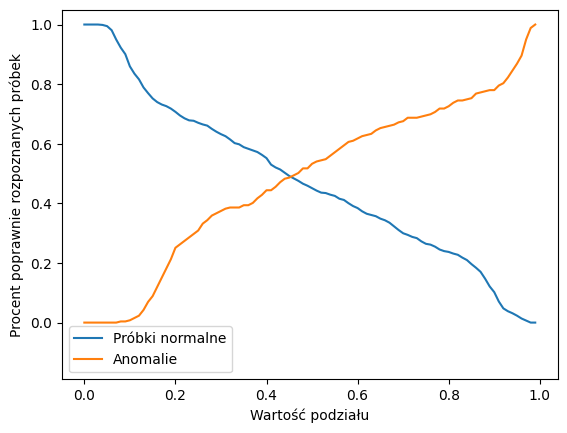

In [7]:
import matplotlib.pyplot as plt

plt.plot(domain, correct_recognized_normal_samples_ratio, label='Próbki normalne')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, label='Anomalie')
plt.xlabel("Wartość podziału")
plt.ylabel("Procent poprawnie rozpoznanych próbek")
plt.ylim(-0.19, 1.05)
plt.legend(loc='lower left')
plt.show()

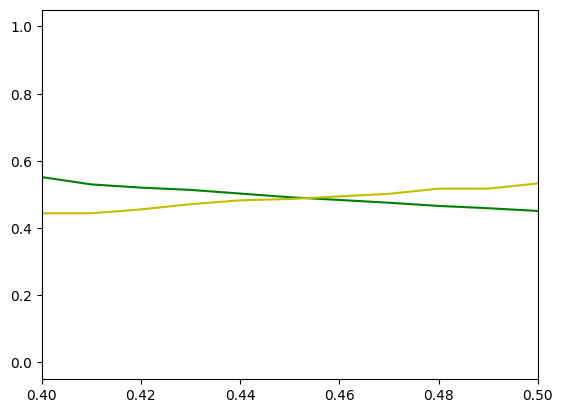

In [8]:
plt.plot(domain, correct_recognized_normal_samples_ratio, 'g')
plt.plot(domain, correct_recognized_anomalous_samples_ratio, 'y')
plt.xlim(0.4, 0.5)
plt.show()

In [9]:
min_difference = float('inf')
for i in range(0, len(correct_recognized_normal_samples_ratio)):
    # Compute the absolute difference between the current pair of values
    difference = abs(correct_recognized_normal_samples_ratio[i] - correct_recognized_anomalous_samples_ratio[i])

    # Check if this pair is closer than the previously found closest pair
    if difference < min_difference:
        # If so, update the closest pair and the minimum difference
        closest_pair = (correct_recognized_normal_samples_ratio[i], correct_recognized_anomalous_samples_ratio[i])
        index = i
        min_difference = difference

print(index)
print(np.mean(closest_pair))

45
0.4891560497827528


In [10]:
print(sample_details[47])

{'factor': 0.47000000000000003, 'correct_recognized_normal_data': 349, 'correct_recognized_anomalous_data': 130}


In [23]:
print((527+117)/1391)

0.4629762760603882


In [14]:
print(normal_data_count)

1141


In [15]:
print(anomalous_data_count)

250


In [ ]:
durations = client.find({'duration': 1, '_id': 0})
values = []
for doc in durations:
    print(doc['duration'])
    values.append(doc['duration'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample dataset (replace this with your own data)
data = [np.random.randint(0, 141) for _ in range(1400)]

# Define the bin edges: [0, 10, 20, ..., 140]
bins = list(range(0, 151, 10))  # 151 is the end to ensure 140 is included

# 1. Aggregate the data using histogram
hist, edges = np.histogram(values, bins=bins)

# 2. Plot the data
plt.figure(figsize=(15, 6))
plt.bar(edges[:-1], hist, width=9)  # Use width=9 to create a small gap between bars for clarity

plt.xlabel("Czas przetwarzania")
plt.ylabel("Liczba obserwacji")
plt.title('ANN')
plt.xticks(edges, labels=[f"{int(edge)}-{int(edge+9)}" for edge in edges[:-1]])

plt.grid(axis='y')
plt.tight_layout()
plt.show()